# Tesco

# Part 1

In [1]:
import pandas as pd
import numpy as np

In [2]:
#import the data files
filepath = '../input/Tesco/'

transactions = pd.read_csv(filepath + 'transactions.tsv',engine = 'python',sep = '\t')
content_train = pd.read_csv(filepath + 'content_train.tsv',engine = 'python',sep = '\t')
content_test = pd.read_csv(filepath + 'content_test.tsv',engine = 'python',sep = '\t')

In [3]:
print(transactions.shape)
print(content_train.shape)
print(content_test.shape)

(2000, 3)
(100000, 27)
(20000, 18)


Q1 - What is the average value of a transaction?

In [4]:
#using the transactions table use the numpy library to calcuate the overall average
print('The average overall transaction value is £' '%.2f' % np.average(transactions['transaction.value']))

The average overall transaction value is £286.18


Q2 - Is there significant difference between spend in different store types?

In [5]:
#using the transactions table, i guess we can look at the range of spending in the different store types.

#firstly - how many store types are there?

print('There are ' + str(transactions['store.type'].nunique()) + ' store types')

There are 4 store types


In [6]:
#let's look at mean, median, and total spend at each store type
transactions.groupby(['store.type']).agg({'transaction.value' :[np.mean,np.median,np.sum,'count']})

transaction.value                          
                        mean   median        sum count
store.type                                            
Express            86.349468   25.795   24350.55   282
Extra             533.165920  111.150  214332.70   402
Metro             421.018131   27.760  205035.83   487
Superstore        155.166490   71.500  128633.02   829

This tells me that there is a mean spend at Tesco Extra of £533! This seams high. Let''s do a simple order by to see if there are any outliers to strip out

In [7]:
transactions = transactions.sort_values('transaction.value',ascending = False)
transactions = transactions.reset_index(drop = True)
transactions.head()

,transaction.value,gender,store.type
0,150032.00,Female,Metro
1,100000.00,Female,Extra
2,11840.25,Female,Extra
3,3180.76,Male,Extra
4,2502.39,Female,Extra


In [8]:
#I think we should strip out the top 10 transactions as they will be skewing the results. £150k at a tesco metro looks wrong!

transactions = transactions.drop(transactions.index[:9])

In [9]:
transactions.groupby(['store.type']).agg({'transaction.value' :[np.mean,np.median,np.sum,'count']})

transaction.value                          
                        mean   median        sum count
store.type                                            
Express            86.349468   25.795   24350.55   282
Extra             225.412563  101.670   88812.55   394
Metro             113.176605   27.745   55003.83   486
Superstore        155.166490   71.500  128633.02   829

This looks a bit more sensible. Tesco Extra has the highest mean and median spend, then Superstore, then Metro, then Express.

Would also be interesting to take a quick look at split between male and female at the stores

In [10]:
transactions.groupby(['store.type','gender']).agg({'transaction.value' :[np.mean,np.median,np.sum,'count']})

transaction.value                         
                               mean   median       sum count
store.type gender                                           
Express    Female        103.181314   26.950  14135.84   137
           Male           70.446276   23.270  10214.71   145
Extra      Female        247.911421  112.750  45367.79   183
           Male          205.899336   95.940  43444.76   211
Metro      Female        129.104170   33.920  31888.73   247
           Male           96.715900   21.830  23115.10   239
Superstore Female        150.004528   77.140  61951.87   413
           Male          160.291226   67.965  66681.15   416

Women tend to spend more at all store types!






# Part 2
## Q3 - Create a model to predict if a user will click on 1st marketing content (e.g. content_1). How well does it perform?

This looks like we need to build a classification model. Two simple examples that spring to mind are logistic regression and a decision tree. Also look at random forest, and SVM.

In [11]:
#import the scikitlearn libraries i am going to use
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
#first lets look at all of the fields and see how many nulls there are
content_train.isnull().sum()

customer.id                       0
content_1                     53978
content_2                     57042
content_3                     72686
content_4                     61921
content_5                     55170
content_6                     50294
content_7                     61804
content_8                     61654
content_9                     51975
express.no.transactions           0
express.total.spend               0
metro.no.transactions             0
metro.total.spend                 0
superstore.no.transactions        0
superstore.total.spend            0
extra.no.transactions             0
extra.total.spend                 0
fandf.no.transactions             0
fandf.total.spend                 0
petrol.no.transactions            0
petrol.total.spend                0
direct.no.transactions            0
direct.total.spend                0
gender                            0
affluency                         0
county                            0
dtype: int64

In [13]:
content_train = content_train.set_index('customer.id')

 - so it looks like there are loads of NaNs in content_1 which we can exclude. 
 - Lets not look at the other contact cards for now either
 - the spend and transactions fields are numerical so are fine, but i think we should normalise

In [14]:
#check the output is binary
content_train = content_train[np.isfinite(content_train['content_1'])]
print(content_train.content_1.value_counts(normalize = True))
print(content_train.content_1.value_counts(normalize = False))

0.0    0.989092
1.0    0.010908
Name: content_1, dtype: float64
0.0    45520
1.0      502
Name: content_1, dtype: int64


1.1% of customers who were shows the card clicked

In [15]:
#create some average transaction fields to make things a bit more manageable
content_train['superstore.average'] = content_train['superstore.total.spend'] / content_train['superstore.no.transactions']
content_train['express.average'] = content_train['express.total.spend'] / content_train['express.no.transactions']
content_train['metro.average'] = content_train['metro.total.spend'] / content_train['metro.no.transactions']
content_train['extra.average'] = content_train['extra.total.spend'] / content_train['extra.no.transactions']
content_train['fandf.average'] = content_train['fandf.total.spend'] / content_train['fandf.no.transactions']
content_train['petrol.average'] = content_train['petrol.total.spend'] / content_train['petrol.no.transactions']
content_train['direct.average'] = content_train['direct.total.spend'] / content_train['direct.no.transactions']

In [16]:
#see if we can spot anything on these continuous fields
f = {'superstore.average' :np.mean,'express.average' :np.mean,'metro.average' :np.mean,'extra.average' :np.mean
     ,'fandf.average' :np.mean,'petrol.average' :np.mean,'direct.average' :np.mean}
print(content_train.groupby('content_1').agg(f))

           express.average  direct.average  petrol.average  fandf.average  \
content_1                                                                   
0.0              15.349167       92.653496       18.803667      34.288885   
1.0              16.037089       92.252752       18.853784      34.374352   

           superstore.average  metro.average  extra.average  
content_1                                                    
0.0                 56.488148      23.169127      57.003395  
1.0                 59.974423      22.387589      52.753154  


Doesn't look like there's a lot of difference between the average spend in each channel for those who clicked and those who didnt click

In [17]:
#now lets take a look at the discrete fields to see if we can spot anything (ignoring county)
print(content_train.groupby('gender').agg({'content_1' : np.mean}))
print(content_train.groupby('affluency').agg({'content_1' : np.mean}))

        content_1
gender           
Female   0.015594
Male     0.006295
           content_1
affluency           
High        0.012240
Low         0.010243
Mid         0.010404
Very High   0.014153
Very Low    0.010088


In [18]:
gender = pd.get_dummies(content_train['gender'])
affluency = pd.get_dummies(content_train['affluency'])
numerical_features = content_train[['superstore.average', 'express.average', 'metro.average',
       'extra.average', 'fandf.average', 'petrol.average', 'direct.average']].fillna(0)
indicator = content_train['content_1']

In [19]:
content_train_updated = pd.concat([indicator,numerical_features,gender,affluency],axis = 1)

In [20]:
content_train_updated.head()

,content_1,superstore.average,express.average,metro.average,extra.average,fandf.average,petrol.average,direct.average,Female,Male,High,Low,Mid,Very High,Very Low
customer.id,,,,,,,,,,,,,,,
3,0.0,52.182000,1.521818,25.976176,3.626923,96.017143,10.238545,111.085000,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,21.963333,3.780789,15.425641,60.969231,24.124444,17.794231,25.504118,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,23.158621,13.116429,2.284912,11.377778,29.322698,4.093556,56.192692,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,0.0,4.896429,3.961489,3.212561,170.455172,120.761667,15.047200,220.368621,0.0,1.0,1.0,0.0,0.0,0.0,0.0
10,0.0,185.022941,34.781607,54.677111,17.364242,0.000000,0.000000,104.464062,1.0,0.0,0.0,0.0,0.0,1.0,0.0


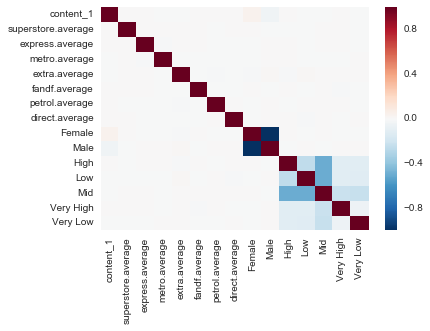

In [21]:
import seaborn as sb
%matplotlib inline
sb.heatmap(content_train_updated.corr())

Doesn't really tell us a lot and don't need it a whole lot for classification

In [22]:
#split into features and target. for now i am going to use all of the features we have included in content_train_updated
y = content_train_updated.ix[:,0].values
X_unscaled = content_train_updated.ix[:,1:].values

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=2)
X_new = selector.fit(X_unscaled, y)

In [24]:
selector.scores_

array([  1.16358211e+02,   1.79322618e+01,   1.10330798e+01,
         1.47795217e+02,   1.16920505e-03,   8.44218233e-03,
         6.16344427e-01,   4.64598856e+01,   4.57347011e+01,
         1.51867505e+00,   3.80447247e-01,   5.37412309e-01,
         2.20703535e+00,   1.48106774e-01])

In [25]:
X_unscaled = selector.transform(X_unscaled)

In [26]:
X_unscaled

array([[  52.182     ,    3.62692308],
       [  21.96333333,   60.96923077],
       [  23.15862069,   11.37777778],
       ..., 
       [   8.18378788,   45.6669697 ],
       [ 104.89546875,  182.80081967],
       [  45.86894737,   22.62727273]])

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X_unscaled)

In [53]:
X

array([[-0.06918786, -0.87725701],
       [-0.58145032,  0.07035495],
       [-0.56118798, -0.74917003],
       ..., 
       [-0.81503917, -0.18252301],
       [ 0.82440322,  2.08368637],
       [-0.17620581, -0.56326618]])

In [54]:
#Try oversampling to see if this reduce the impact of class imbalance
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)
pd.DataFrame(y_resampled,columns = ['Indicator']).Indicator.value_counts(normalize = True)

1.0    0.5
0.0    0.5
Name: Indicator, dtype: float64

# Logistic Regression

In [55]:
clf = LogisticRegression(class_weight='balanced')
clf_scores = cross_val_score(clf, X_resampled, y_resampled, scoring='neg_log_loss', cv=5)
print(clf_scores)
print(np.mean(clf_scores))

[-0.69204942 -0.69247268 -0.69249836 -0.69210402 -0.69216055]
-0.692257004758


In [56]:
clf.fit(X_resampled,y_resampled)
clf_predicted = clf.predict_proba(X)
clf_predicted_label = clf.predict(X)

# Decision Trees

In [57]:
my_tree = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(my_tree, X_resampled,y_resampled, scoring='neg_log_loss', cv=5)
print(tree_scores)
print(np.mean(tree_scores))

[-0.20676223 -0.24280335 -0.21814363 -0.20296842 -0.18969012]
-0.21207355014


Performing well, but is it overfitting with no parameters?

In [58]:
max_depth = 10
min_samples_split = 5
my_tree_two = tree.DecisionTreeClassifier(max_depth = 10, min_samples_split = 5, random_state = 1)
tree_scores = cross_val_score(my_tree_two, X_resampled,y_resampled, scoring='neg_log_loss', cv=5)
print(tree_scores)
print(np.mean(tree_scores))

[-0.56755189 -0.61046928 -0.57737303 -0.60634729 -0.56057736]
-0.584463771413


In [59]:
my_tree_two.fit(X_resampled,y_resampled)
my_tree_two_predicted = my_tree_two.predict_proba(X)
my_tree_two_predicted_label = my_tree_two.predict(X)

# Random Forest

In [60]:
clfrf = RandomForestClassifier(max_depth=4, random_state=0, bootstrap=True)
rf_scores = cross_val_score(clfrf, X_resampled,y_resampled, scoring='neg_log_loss', cv=5)
print(rf_scores)
print(np.mean(rf_scores))

[-0.67002289 -0.67106186 -0.67062226 -0.67090012 -0.6707969 ]
-0.670680805608


In [34]:
clfrf.fit(X_resampled,y_resampled)
clfrf_predicted = clfrf.predict_proba(X)
clfrf_predicted_label = clfrf.predict(X)

# SVM

In [33]:
clfsvm = svm.SVC(probability=True, class_weight='balanced')
svm_scores = cross_val_score(clfsvm, X_resampled,y_resampled, scoring='neg_log_loss', cv=5)
print(svm_scores)
print(np.mean(svm_scores))

[-0.47801351 -0.47865182 -0.48288125 -0.47868504 -0.48241206]
-0.480128735233


In [35]:
clfsvm.fit(X_resampled,y_resampled)
clfsvm_predicted = clfsvm.predict_proba(X)
clfsvm_predicted_label = clfsvm.predict(X)

# Confusion Matrices

Worth looking at whether or not the model will actually predict anything. As we have imbalanced classes we could predict well by just predicting '0' every time

In [36]:
print('Logistic')
print(confusion_matrix(y,clf_predicted_label))
print(np.mean(clf_scores))
print('Decision Tree')
print(confusion_matrix(y,my_tree_two_predicted_label))
print(np.mean(tree_scores))
print('Random Forest')
print(confusion_matrix(y,clfrf_predicted_label))
print(np.mean(rf_scores))
print('SVM')
print(confusion_matrix(y,clfsvm_predicted_label))
print(np.mean(svm_scores))

Logistic
[[23271 22249]
 [  148   354]]
-0.666893001835
Decision Tree
[[25605 19915]
 [   49   453]]
-0.510640730397
Random Forest
[[24945 20575]
 [  145   357]]
-0.643314153089
SVM
[[30043 15477]
 [   53   449]]
-0.480128735233


This is a tricky one. SVM does have a low log_loss score and at least predicts some clicks, whereas the random forest just seems to predict nothing. 

However, the SVM creates a large number of false negatives, which presumably will reappear in test

Will go for SVM to create the prediction file. To further improve we could look at:
 - Feature Interaction
 - More Careful Feature Selection
 - Penalising the model using CV
 - Neural Networks???

# Apply the chosen model (SVM) on the test data set and submit

In [37]:
#create the fields
content_test['superstore.average'] = content_test['superstore.total.spend'] / content_test['superstore.no.transactions']
content_test['express.average'] = content_test['express.total.spend'] / content_test['express.no.transactions']
content_test['metro.average'] = content_test['metro.total.spend'] / content_test['metro.no.transactions']
content_test['extra.average'] = content_test['extra.total.spend'] / content_test['extra.no.transactions']
content_test['fandf.average'] = content_test['fandf.total.spend'] / content_test['fandf.no.transactions']
content_test['petrol.average'] = content_test['petrol.total.spend'] / content_test['petrol.no.transactions']
content_test['direct.average'] = content_test['direct.total.spend'] / content_test['direct.no.transactions']

In [38]:
content_test.head()

,customer.id,express.no.transactions,express.total.spend,metro.no.transactions,metro.total.spend,superstore.no.transactions,superstore.total.spend,extra.no.transactions,extra.total.spend,fandf.no.transactions,...,gender,affluency,county,superstore.average,express.average,metro.average,extra.average,fandf.average,petrol.average,direct.average
0,100001,103,1199.25,48,294.87,56,2281.35,44,108.05,17,...,Male,Very Low,Norfolk,40.738393,11.643204,6.143125,2.455682,22.155882,NaN,5.638571
1,100002,45,59.75,40,1174.78,60,3218.08,61,2138.64,69,...,Male,Mid,Greater London,53.634667,1.327778,29.369500,35.059672,30.371159,16.490286,19.002308
2,100003,40,95.37,43,842.20,45,1543.47,18,1401.68,38,...,Male,High,Tyne and Wear,34.299333,2.384250,19.586047,77.871111,6.030789,NaN,257.540256
3,100004,59,1362.03,30,474.25,48,120.68,47,32.65,0,...,Male,Mid,Greater Manchester,2.514167,23.085254,15.808333,0.694681,NaN,8.864286,88.934839
4,100005,101,4565.07,39,910.03,35,467.30,34,292.99,30,...,Female,High,Derby,13.351429,45.198713,23.334103,8.617353,58.571667,33.055000,37.653864


In [39]:
gender_test = pd.get_dummies(content_test['gender'])
affluency_test = pd.get_dummies(content_test['affluency'])
numerical_features_test = content_test[['superstore.average', 'express.average', 'metro.average',
       'extra.average', 'fandf.average', 'petrol.average', 'direct.average']].fillna(0)
customer_id = content_test['customer.id']

content_test_updated = pd.concat([customer_id,numerical_features_test,gender_test,affluency_test],axis = 1)

In [40]:
content_test_updated.head()

,customer.id,superstore.average,express.average,metro.average,extra.average,fandf.average,petrol.average,direct.average,Female,Male,High,Low,Mid,Very High,Very Low
0,100001,40.738393,11.643204,6.143125,2.455682,22.155882,0.000000,5.638571,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,100002,53.634667,1.327778,29.369500,35.059672,30.371159,16.490286,19.002308,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,100003,34.299333,2.384250,19.586047,77.871111,6.030789,0.000000,257.540256,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,100004,2.514167,23.085254,15.808333,0.694681,0.000000,8.864286,88.934839,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,100005,13.351429,45.198713,23.334103,8.617353,58.571667,33.055000,37.653864,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [41]:
X_test_unscaled = content_test_updated.ix[:,1:].values

In [42]:
X_test_unscaled
X_test = scaler.transform(X_test_unscaled)
#this uses the mean and SD from the training set as opposed to set. more rows in training data so more accurate mean and SD

In [43]:
clfsvm_predicted_label_test = clfsvm.predict(X_test)

In [44]:
results = pd.DataFrame(clfsvm_predicted_label_test,customer_id,columns = ['content_1'])

In [45]:
results.content_1.value_counts(normalize = True)

0.0    0.6481
1.0    0.3519
Name: content_1, dtype: float64

In [46]:
results.to_csv('../input/Tesco/content_1_results.csv',sep = ',',index_label = ['customer.id'])

# q4 - Please give a high-level description of how you would create a production system to deliver the most relevant content card to the user on the website. Bear in mind:
The spend and website interaction data would be delivered (updated) daily
The decision as to what content to show each customer needs to be delivered in real-time (via an API)
The whole process needs to be automated, with no manual interaction
Please state what tools and technology you would use to achieve this

This is a similar concept to a recommender system, whereby a user will be recommended the most appropriate content card.

I would probably use an algorithm such as Alternating Least Squares as a product recommender for the user. This is best done in Spark, and we can talk to a Spark cluster in Python through PySpark. This can then be trained and cross validated to come up with an optimal set of hyper parameters. The model would then be ready for implementation, where each user has at least one product (or content card) to be recommended to them.


Once recommendations are made, we can shut down our spark cluster and make the list of users and recommendations available through an API.


Data will be constantly flowing into the model, and the engine will need to be able to handle growing volumes of data and compute the recommendations. To handle this such a data pipeline, I would:
	 - have the user data in a DB like Redshift or SQL
	 - Data for the recommendations would then be inserted into a flat file like a csv
	 - Our Spark cluster could then be initialised
	 - Our python script (PySpark) to generate the model would then be run and upload list of users and recommendations to DB
	 - The API would then make this data available to the website, forwarding the user ID as its main parameter, to generate the        appropriate content card(s)
		

AWS would be my preferred service for managing this pipeline.